# TTA-45046 Financial Engineering
## Project Work 2017

This project work is about pricing OP Pohjola structured instrument OP Nokia Call 3/2017. The terms of the contract are presented here: [OP Nokia Call 3/2017 Terms](https://uusi.op.fi/documents/20556/9985268/Lainaehdot+3+2017/74468110-5085-4496-bbdc-87e759dd3317) in Finnish.

In short objective of the project work is to price above mentioned derivate using Monte Carlo simulating with antithetic varies. The underlying asset is Euro-nominated Nokia stock in Helsinki Stock Exchange. Rest of the details can be found on this notebook.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import datetime as dt
from __future__ import division # Python 3 like division behaviour, easier to get floats

# For plotting
import matplotlib.pyplot as plt
%matplotlib inline

# For data wrangling
import requests
from bs4 import BeautifulSoup

# Set constants
TRADING_DAYS = 252 # in a year
MATURITY = dt.datetime(2020, 4, 3) # contract's termination day

Pretending that we're doing this valuation on the effective date 15th of March 2017.

In [2]:
today = dt.datetime(2017, 3, 15)

## Estimating parameters

Most of the general parameters are already given, only asset specific parameters, like volatility, dividend yield and dividend distribution date needs to be estimated.

I'll load the Nokia stock information from Nasdaq OMX homepage to estimate volatility. The file is already downloaded to the working directory and the name is 'NOKIA-2016-03-15-2017-03-15.csv'.

In [3]:
df = pd.read_csv('NOKIA-2016-03-15-2017-03-15.csv', sep=';', decimal=',')
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Bid,Ask,Opening price,High price,Low price,Closing price,Average price,Total volume,Turnover,Trades
0,2017-03-15,4.98,4.99,4.98,5.01,4.97,4.99,4.99,13217726,65936757.39,6887
1,2017-03-14,4.98,4.98,5.00,5.01,4.96,4.98,4.98,13052841,65047032.05,7042
2,2017-03-13,4.99,4.99,5.00,5.01,4.98,5.00,4.99,11870070,59276069.25,5955
3,2017-03-10,4.99,4.99,4.96,5.01,4.94,4.99,4.99,15236854,75965143.28,8136
4,2017-03-09,4.95,4.96,4.88,4.97,4.87,4.95,4.94,18054074,89143715.03,8775


Estimate the stock volatility of log prices for the underlying asset.

In [4]:
daily_log_returns = np.log(1 + df['Closing price'].pct_change())
sigma = daily_log_returns.std() / np.sqrt(1 / TRADING_DAYS)
print 'Nokia stock volatility in the time period 15-03-2016 - 15-03-2017:', sigma

Nokia stock volatility in the time period 15-03-2016 - 15-03-2017: 0.314821472072


To estimate Nokia's dividend information, I will get the information from Kauppalehti web page, but it's quite slow so the request for HTML data is placed into seperate cell.

In [5]:
url = 'https://www.kauppalehti.fi/5/i/porssi/osingot/osinkohistoria.jsp?klid=1050'
r = requests.get(url)

Then I will parse all the data into a pandas dataframe. I used this post  http://stackoverflow.com/questions/23377533/python-beautifulsoup-parsing-table as a guide.

In [6]:
# Parse data
data = []
soup = BeautifulSoup(r.content, 'lxml')
table = soup.find_all('table', attrs={'class':'table_stockexchange'})
rows = table[1].find_all('tr')
for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols if ele])

# Set data into pandas dataframe
headers = ['year', 'date', 'adjusted_eur', 'amount', 'currency', 'yield']
df_dividend = pd.DataFrame.from_records(data[1:], columns=headers)

# Fix the data types
df_dividend['year'] = df_dividend['year'].astype(str).astype(int)
df_dividend['date'] = pd.to_datetime(df_dividend['date'])
for feature in ['adjusted_eur', 'amount', 'yield']:
    df_dividend[feature] = df_dividend[feature].astype(str).astype(float)

df_dividend.head()

,year,date,adjusted_eur,amount,currency,yield
0,2017,2017-05-24,0.17,0.17,EUR,3.4
1,2016,2016-06-17,0.26,0.26,EUR,5.1
2,2015,2015-06-05,0.14,0.14,EUR,2.4
3,2014,2014-06-18,0.37,0.37,EUR,6.3
4,2013,2013-08-05,0.00,0.00,EUR,0.0


First I estimate the dividend yield of Nokia stock. According to the project work instructions one should use last five years data to estimate the dividend yield.

In [7]:
estimation_period = 5
div_yield = df_dividend['yield'][:estimation_period].mean()
print 'The mean of Nokia stock dividend yield during the last five years:', div_yield

The mean of Nokia stock dividend yield during the last five years: 3.44


Next I will estimate the dividend paying date by taking the mean dividend distribution date of last five years. Then calculate future dividend distribution dates during the maturity of the derivative contract. I am still using the five-year estimation period for the date calculations.

In [8]:
years = pd.to_datetime(df_dividend['year'], format='%Y')
mean_dividend_date = (df_dividend['date'][:estimation_period] - years[:estimation_period]).mean()

dividend_dates = [dt.datetime(year, 1, 1) + mean_dividend_date for year in range(2017, 2020)]
print 'Estimated dividend paying dates:', [date.strftime('%d.%m.%Y') for date in dividend_dates]

Estimated dividend paying dates: ['20.06.2017', '20.06.2018', '20.06.2019']


Then I will change these dates into linear time, the effective day as the starting point. Since the dates are estimated as calendar days so I will divide by whole calendar year (365 days, thank god no leap year in the time period), not by amount of trading days.

In [9]:
div_dates = np.array([(date - today).days for date in dividend_dates]) / 365
print 'In linear time dividends are distributed at the following times:', div_dates

In linear time dividends are distributed at the following times: [ 0.26575342  1.26575342  2.26575342]


Now I will set the rest parameters given in the project work instructions document.

In [10]:
notional_amount = 1000
fixed_rate = 0.084
barrier = -0.30
rf = 0.001 # risk-free rate
n_sim = int(1e6)

# These dates are in linear times from the effective date
obs_dates = np.array([6/12 - 1/252, 1 - 2/252, 1 + 6/12 - 1/252, 2, 2 + 6/12 + 1/252, 3 + 2/252])
pay_dates = np.array([6/12 + 12/252, 1 + 12/252, 1 + 6/12 + 12/252, 2 + 12/252, 2 + 6/12 + 12/252, 3 + 12/252])

S0 = df['Closing price'][0] # Inial asset price
TIMESTEPS = len(obs_dates)

## Stock price process with dividends

Stock price process follows geometric brownian motion

$$ S_{t+ \Delta t} = S_t \times\ e^{(r - \frac{1}{2} \sigma^2)\Delta t  + \sigma \sqrt{\Delta t} \epsilon_t }.$$

But there is also need to adjust stock price process for dividends as of follows

$$ S^*_{\tau_i} = S_{\tau_i} - e^{-r (T_{div_{\tau_i;\tau_{i+1}}} - \tau_i) }\ \times Q_{\tau_i;\tau_{i+1}},$$ 

where $S^*$ is dividend adjusted stock price, $T_{div_{\tau_i;\tau_{i+1}}}$ dividend distribution time and $Q_{\tau_i;\tau_{i+1}}$ is the amount of dividend. In the instructions it is proposed to first check the early termination condition at the initial step, then adjust possible dividend and finally calculate stock price at the next step. 

However, because of vectorization I first simulate the stock prices paths without dividends and I need to adjust the dividends.

$$ S^*_{t+ \Delta t} = S_t^* \times\ e^{(r - \frac{1}{2} \sigma^2)\Delta t  + \sigma \sqrt{\Delta t} \epsilon_t }, $$

where we apply dividend adjusted geometric brownian motion.

$$ S^*_{\tau_i+ \Delta t} = 
    (S_{\tau_i} 
    - e^{-r (T_{div_{\tau_i;\\\tau_{i+1}}} - \tau_i)}\ 
        \times Q_{\tau_i;\tau_{i+1}}) 
    \times\ e^{(r - \frac{1}{2} \sigma^2)\Delta t  + \sigma \sqrt{\Delta t} \epsilon_{t_i} }$$

$$
S^*_{\tau_i+ \Delta t} = 
    S_{\tau_i} 
        \times\ e^{(r - \frac{1}{2} \sigma)\Delta t  + \sigma \sqrt{\Delta t} \epsilon_{t_i}}
    - e^{-r (T_{div_{\tau_i;\tau_{i+1}}} - \tau_i)}\ 
        \times\ e^{(r - \frac{1}{2} \sigma)\Delta t  + \sigma \sqrt{\Delta t} \epsilon_{t_i}}
        \times Q_{\tau_i;\tau_{i+1}},
$$

where $S_{\tau_i}e^{(r - \frac{1}{2} \sigma)\Delta t  + \sigma \sqrt{\Delta t} \epsilon_{t_i}}$ is the original geometric brownian motion. Consequently,

$$
S^*_{\tau_i+ \Delta t} = 
    S_{t+ \Delta t}
    - e^{-r (T_{div_{\tau_i;\tau_{i+1}}} - \tau_i)}\  
        \times\ e^{(r - \frac{1}{2} \sigma)\Delta t  + \sigma \sqrt{\Delta t} \epsilon_{t_i}}
        \times Q_{\tau_i;\tau_{i+1}},
$$

so first I need to discount the amount of dividend to previous observation date and then apply the diffusion process, however as stock price is also simulated at dividend distribution dates discounting is not necessary, thus finally 

$$
S^*_{t_i+ \Delta t} = 
    S_{t+\Delta t}
    - e^{(r - \frac{1}{2} \sigma)\Delta t  + \sigma \sqrt{\Delta t} \epsilon_{t_i}}
        \times Q_{t}
$$

In brief I need to make same kind of diffusion process for dividends as for the stock price from distribution date onwards and subtract the amount of dividend in the future dates.

In [11]:
def simulate_stock_price_paths(S0, sigma, obs_dates, div_dates, div_yield, rf, n_sim):
    
    # Linear time difference between each date
    all_dates = np.hstack((0, np.hstack((div_dates, obs_dates))))
    all_dates = np.sort(all_dates)
    dT = np.diff(all_dates)

    # Generate the random variables (stock price pathes are vertical, simulations horizontal)
    eps = np.random.randn(n_sim, len(dT))

    # Traditional Monte Carlo stock price paths
    Xt = (rf - 0.5 * sigma ** 2) * dT + sigma * np.sqrt(dT) * eps
    Xt = np.hstack((np.zeros((n_sim, 1)), np.cumsum(Xt, axis=1)))
    St = (S0 * np.exp(Xt))

    # Antithetic Monte Carlo stock price paths
    Xt_at = (rf - 0.5 * sigma ** 2) * dT - sigma * np.sqrt(dT) * eps
    Xt_at = np.hstack((np.zeros((n_sim, 1)), np.cumsum(Xt_at, axis=1)))
    St_at = S0 * np.exp(Xt_at)

    # Adjusting for dividends
    for div_date in div_dates:

        # Find out correct time in terms of all dates
        index = (np.where( all_dates == div_date))[0][0]
  
        # Amount of distributed dividend
        Q = St[:,index] * div_yield / 100 

        # Apply dividends to the stock price processes
        Xt_temp = (Xt.T - Xt[:,index]).T # diffusion process from dividend date onwards
        Qt = (Q * np.exp(Xt_temp[:,index:]).T).T # dividend's price process
        St[:,index:] -= Qt

        # And the same adjustment for antithetic paths
        Xt_at_temp = (Xt_at.T - Xt_at[:,index]).T
        Q_at = St_at[:,index] * div_yield / 100
        Qt_at = (Q_at * np.exp(Xt_at_temp[:,index:]).T).T
        St_at[:,index:] -= Qt_at

    
    # Mask to filter out dividend dates from stock price process
    div_mask = np.in1d(all_dates, div_dates)

    return St[:,~div_mask], St_at[:,~div_mask]

## Pricing


According to instructions contract will early terminate in case stock price is greater than stock price at t=0 at any observation date, otherwise contract terminate at maturity. This function returns the correct period when contract will terminate given stock price path.

In [12]:
def determine_termination_period(St):
    for i in range(1, TIMESTEPS):
        if St[i] >= St[0]:
            return int(i)
    return int(TIMESTEPS) # no early termination

This function determines coefficient for the payoff at the maturity (no early termination). Coefficient is used later to calculate contract's payoff at the maturity.

In [13]:
def maturity_termination_coefficient(St, barrier, fixed_rate):
    
    coefficient = (St[-1] / St[0]) - 1

    # Stock price finally is higher than initial stock price
    if coefficient >= 0:
        return (1 + TIMESTEPS * fixed_rate)
    
    # Stock price less than initial stock price but coefficient is higher than the given barrier
    elif coefficient >= barrier:
        return 1
    
    # Stock price at maturity / initial stock price coefficient is less than the given barrier
    else:
        return (coefficient + 1)

This function calculates the payoff of the structured instrument given the stock price path taking into account different termination periods.

In [14]:
def calculate_payoff(St, pay_dates, fixed_rate, barrier, notional_amount, rf):

    # Determine stock price path's termination period
    termination_period = determine_termination_period(St)
    
    # Payoff at maturity
    if termination_period == TIMESTEPS:
        payoff = notional_amount * maturity_termination_coefficient(St, barrier, fixed_rate)
   
    # Early termination
    else:
        payoff = notional_amount * (1 + termination_period * fixed_rate)

    dT = pay_dates[termination_period - 1]

    return np.exp(-rf * dT) * payoff

Function to run the pricing algorithm.

The function returns n_sim amount of prices, both using antithetic variates and only traditional Monte Carlo methods.

In [15]:
def price_derivative(S0, sigma, obs_dates, pay_dates, div_dates, div_yield, barrier, fixed_rate, 
                     notional_amount, rf, n_sim):
    
    # Simulate dividend-adjusted stock price paths
    St, St_at = simulate_stock_price_paths(S0, sigma, obs_dates, div_dates, div_yield, rf, n_sim)
    
    prices = np.zeros(n_sim)
    prices_at = np.zeros(n_sim)

    # Apply pricing algorithm for each stock price path
    for i in range(n_sim):
        prices[i] = calculate_payoff(St[i], pay_dates, fixed_rate, barrier, notional_amount, rf)
        prices_at[i] = calculate_payoff(St_at[i], pay_dates, fixed_rate, barrier, notional_amount, rf)
    
    prices_at = (prices_at + prices) / 2
        
    return prices_at, prices

In [16]:
#%%timeit
prices_at, prices = price_derivative(S0, sigma, obs_dates, pay_dates, div_dates, div_yield, 
                                      barrier, fixed_rate, notional_amount, rf, n_sim)

For 1,000,000 simulations function takes around 16 seconds to run, which is not unbearable as the derivative does not need to be priced in real time during trading. 

Stock price process is vectorized and only takes few seconds seconds to run. The problematic part is the pricing algorithm as it is applied per stock price path both for traditional Monte Carlo path and antithetic Monte Carlo path. Furthermore *determine_termination_period* function has to check every observation point. It might not matter significantly now that there are only six observation dates, but if there would be more observation dates it would slow down algorithm greatly.  

## Results

Using traditional Monte Carlo methods
Mean of derivative price: 948.563867987
Std of derivative price: 321.043642073

Using Antithetic Monte Carlo methods
Mean of derivative price: 948.297033288
Std of derivative price: 195.338524435


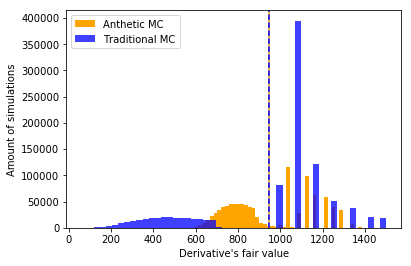

In [17]:
print 'Using traditional Monte Carlo methods'
print 'Mean of derivative price:', prices.mean()
print 'Std of derivative price:', prices.std()
print 
print 'Using Antithetic Monte Carlo methods'
print 'Mean of derivative price:', prices_at.mean()
print 'Std of derivative price:', prices_at.std()


# Plot histograms of price distribution
plt.hist(prices_at, label='Anthetic MC', color='orange', bins=50)
plt.axvline(prices_at.mean(), color='orange', linestyle='solid', linewidth=1.5)
plt.hist(prices, label='Traditional MC', color='blue', bins=50, alpha=0.75)
plt.axvline(prices.mean(), color='blue', linestyle='dashed', linewidth=1.5)

plt.xlabel("Derivative's fair value")
plt.ylabel('Amount of simulations')
plt.legend()
plt.show()

Two important points can be obtained from the results:

1. Technicaility-wise pricing the derivative using Monte Carlo with antithetic variates greatly decreases the volatility of the results, which was expected as it is the main contribution of the algorithm. You can see this behaviour also from the graph as there are less extreme values and the probability mass is more concentraded in the middle.  

2. Pricing-wise OP Pohjola on average is making a profit of 50 euros per contract, since notional amount is 1000 euros. This is because the profits over 1000 euros have discrete outcomes, thus investor's up-side is limited.

Personally I found profit of about 5% very small since I was expecting marketing costs, salaries of both sales and trading side, and also transaction costs for later hedging would be much higher. Presumably, huge amount of contracts (13,090) will provide healthy profit. Also since OP Pohjola has other contracts, hedging positions can cancel each other out, thus hedging less is needed.

## Sensitivity analysis

Finally here is a sensitivity analysis volatility set at 80%, 100% and 120% of original estimated volatility.

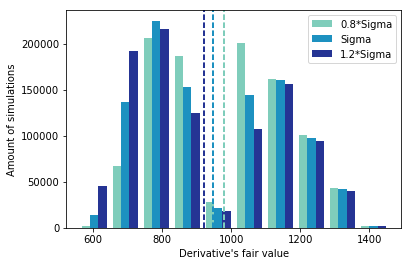

In [18]:
sigmas = [0.8*sigma, sigma, 1.2*sigma]
prices = np.array([price_derivative(S0, sig, obs_dates, pay_dates, div_dates, div_yield, 
                                      barrier, fixed_rate, notional_amount, rf, n_sim)[0] for sig in sigmas])
data = [prices[i] for i in range(len(sigmas))]

labels = ['0.8*Sigma', 'Sigma', '1.2*Sigma']
colors = ['#7fcdbb', '#1d91c0', '#253494']

plt.hist(data, histtype='bar', label=labels, color=colors)
for i in range(len(data)):
    plt.axvline(data[i].mean(), color=colors[i], linestyle='dashed', linewidth=2)

plt.legend()
plt.xlabel("Derivative's fair value")
plt.ylabel('Amount of simulations')
plt.show()

The graph tells that the lower the volatility the higher the derivative's fair value and vice versa. Thus one could make an educated guess that OP Pohjola expects Nokia stock's volatility increase in the coming years.